## Setup

In [1]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import (
    simple_plot,
    plot_train_val_losses
)
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

Using TensorFlow backend.


## Load data

> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
weekday      int64
dtype: object

close   open   high    low  volume  missing  weekday
datetime                                                        
2015-02-01  214.8  218.0  220.8  208.5    6.19        0        6
2015-02-02  238.0  214.8  242.0  214.8    6.42        0        0
2015-02-03  227.4  238.0  244.4  223.8   17.76        0        1
2015-02-04  227.0  227.4  231.0  220.0   14.31        0        2
2015-02-05  217.0  227.0  228.9  213.6    4.31        0        3

close    open    high     low  volume  missing  weekday
datetime                                                            
2018-10-09  6588.8  6604.8  6623.1  6553.1    2.25        0        1
2018-10-10  6517.5  6588.7  6589.8  6400.0    5.18        0        2
2018-10-11  6161.0  6517.5  6518.4  6067.0    9.62        0        3
2018-10-12  6184.9  6152.8  6238.3  6109.8    3.25        0        4
2018-10-13  6195.0  6180.8  6214.1  6168.8    2.27        0        5

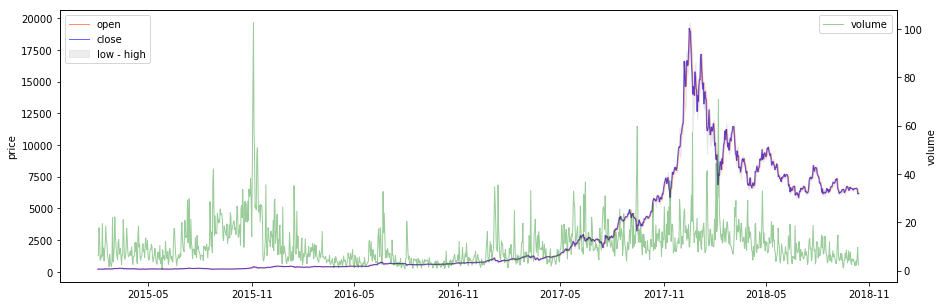

In [3]:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
data24h['weekday'] = data24h.index.dayofweek
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

## Size 3|3

### LR=1e-3

data ~ (600, 1)
--- 0.014s to model compilation time


--- Created model id: 140222899281232
Tensor("lstm_11_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
lstm_12 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_6/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/100
277/277 [==============================] - 2s 6ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 2/100
277/277 [===========================

277/277 [==============================] - 0s 826us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 71/100
277/277 [==============================] - 0s 872us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 72/100
277/277 [==============================] - 0s 757us/step - loss: 0.0015 - val_loss: 0.0014
Epoch 73/100
277/277 [==============================] - 0s 682us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 74/100
277/277 [==============================] - 0s 892us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 75/100
277/277 [==============================] - 0s 795us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 76/100
277/277 [==============================] - 0s 997us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 77/100
277/277 [==============================] - 0s 787us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 78/100
277/277 [==============================] - 0s 788us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 79/100
277/277 [==============================] - 0s 818us/step - loss:

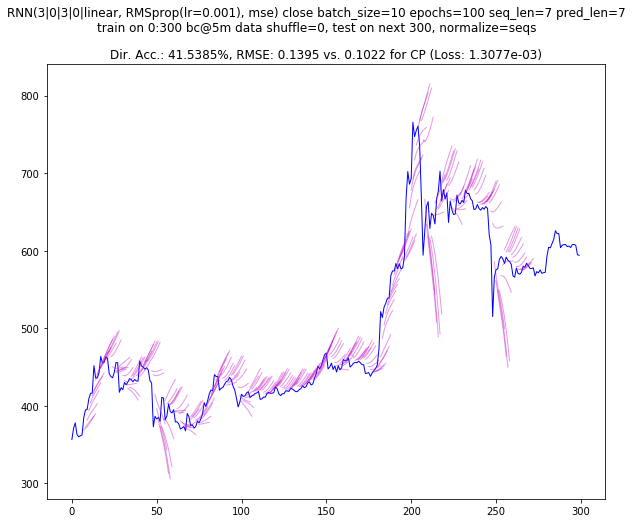

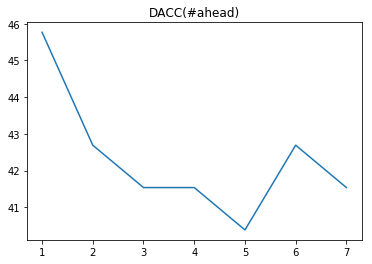

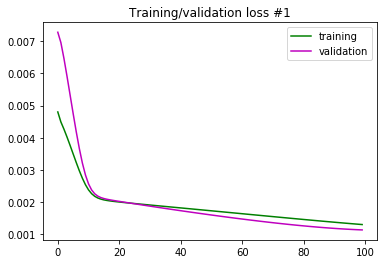

--- 25.167s to run experiment



In [8]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0, 3, 0],
            lr=1e-3,
        ),
        # training:
        epochs=100,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140221660907088
Tensor("lstm_121_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_121 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
lstm_122 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dense_61 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_61/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/50
277/277 [==============================] - 9s 33ms/step - loss: 0.0045 - val_loss: 0.0071
Epoch 2/50
277/277 [==========================

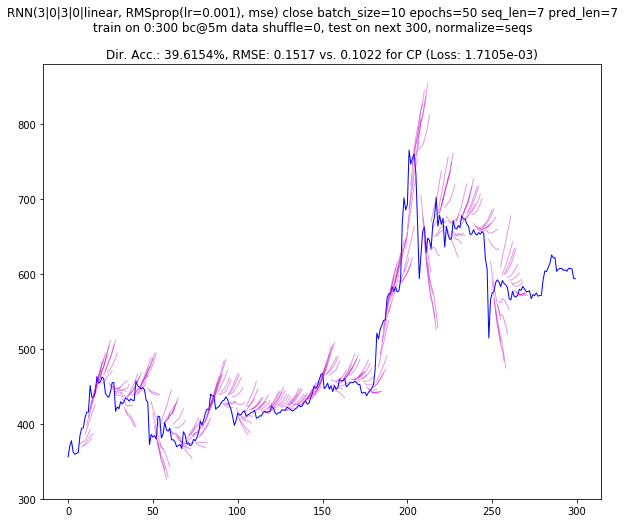

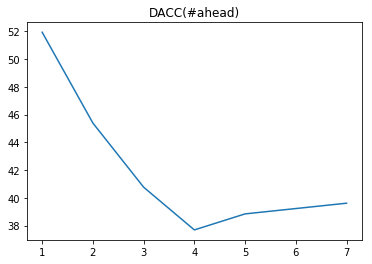

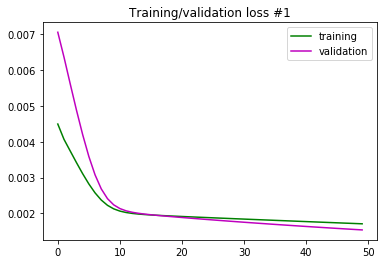

--- 28.899s to run experiment



In [39]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0, 3, 0],
            lr=1e-3,
        ),
        # training:
        epochs=50,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140221813754704
Tensor("lstm_103_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_103 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
lstm_104 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_52/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/6
277/277 [==============================] - 9s 31ms/step - loss: 0.0058 - val_loss: 0.0097
Epoch 2/6
277/277 [============================

Train on 277 samples, validate on 15 samples
Epoch 1/6
277/277 [==============================] - 8s 29ms/step - loss: 0.0058 - val_loss: 0.0094
Epoch 2/6
277/277 [==============================] - 0s 740us/step - loss: 0.0056 - val_loss: 0.0095
Epoch 3/6
277/277 [==============================] - 0s 801us/step - loss: 0.0056 - val_loss: 0.0094
Epoch 4/6
277/277 [==============================] - 0s 870us/step - loss: 0.0055 - val_loss: 0.0093
Epoch 5/6
277/277 [==============================] - 0s 832us/step - loss: 0.0054 - val_loss: 0.0091
Epoch 6/6
277/277 [==============================] - 0s 815us/step - loss: 0.0053 - val_loss: 0.0090
--- 10.764s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (

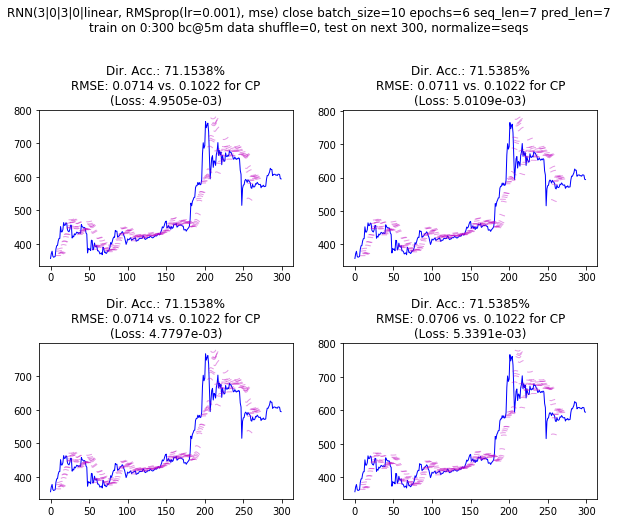

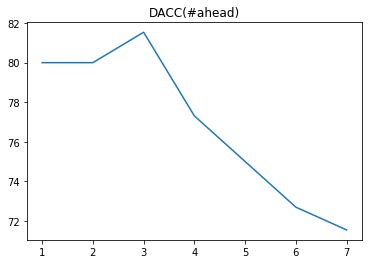

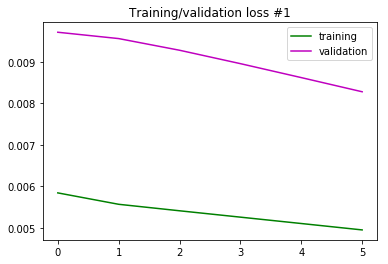

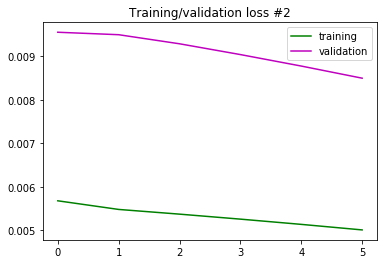

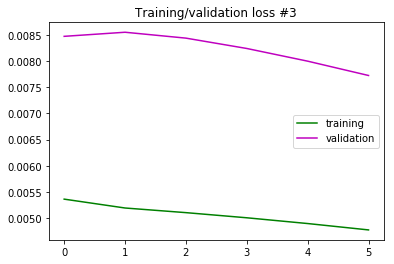

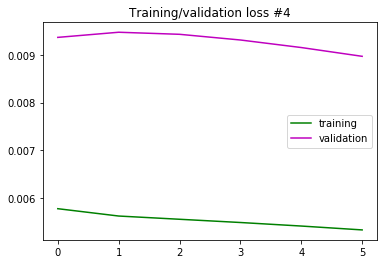

--- 60.672s to run experiment



In [36]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0, 3, 0],
            lr=1e-3,
        ),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

#### add dropout

data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140221638166224
Tensor("lstm_123_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_123 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_9 (Dropout)          (None, 7, 3)              0         
_________________________________________________________________
lstm_124 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_10 (Dropout)         (None, 3)                 0         
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
__________________________________________________________

Train on 277 samples, validate on 15 samples
Epoch 1/6
277/277 [==============================] - 10s 36ms/step - loss: 0.0062 - val_loss: 0.0106
Epoch 2/6
277/277 [==============================] - 0s 786us/step - loss: 0.0059 - val_loss: 0.0106
Epoch 3/6
277/277 [==============================] - 0s 840us/step - loss: 0.0058 - val_loss: 0.0102
Epoch 4/6
277/277 [==============================] - 0s 925us/step - loss: 0.0057 - val_loss: 0.0098
Epoch 5/6
277/277 [==============================] - 0s 908us/step - loss: 0.0053 - val_loss: 0.0094
Epoch 6/6
277/277 [==============================] - 0s 829us/step - loss: 0.0053 - val_loss: 0.0089
--- 13.258s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting 

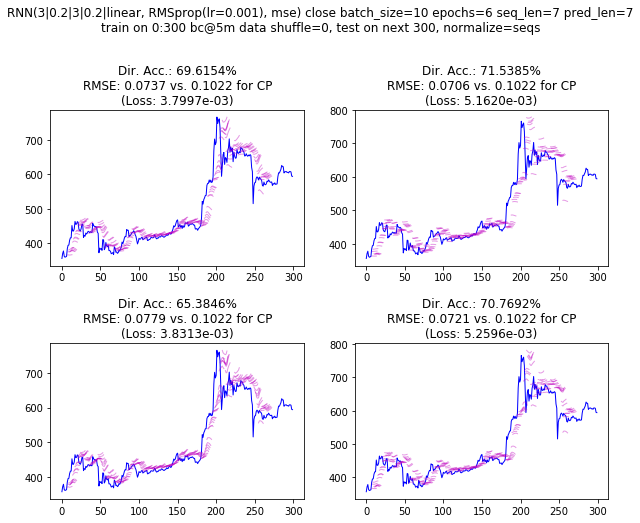

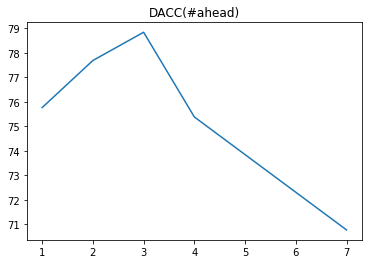

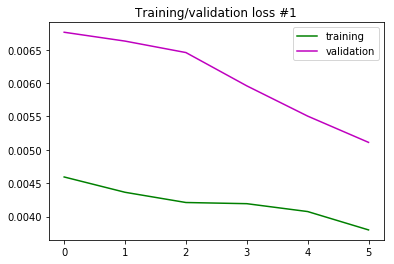

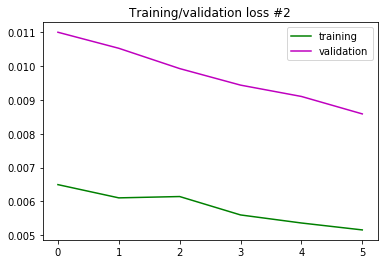

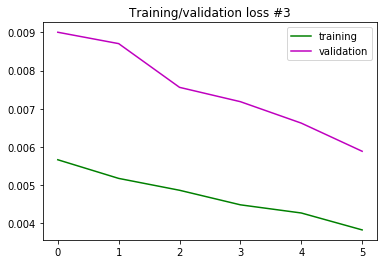

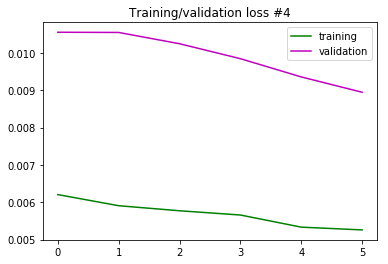

--- 74.148s to run experiment



In [40]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0.2, 3, 0.2],
            lr=1e-3,
        ),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

### LR=1e-2

data ~ (600, 1)
--- 0.014s to model compilation time


--- Created model id: 140222899172176
Tensor("lstm_13_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
lstm_14 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_7/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/100
277/277 [==============================] - 2s 6ms/step - loss: 0.0046 - val_loss: 0.0101
Epoch 2/100
277/277 [===========================

277/277 [==============================] - 0s 676us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 71/100
277/277 [==============================] - 0s 688us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 72/100
277/277 [==============================] - 0s 680us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 73/100
277/277 [==============================] - 0s 817us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 74/100
277/277 [==============================] - 0s 736us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 75/100
277/277 [==============================] - 0s 692us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 76/100
277/277 [==============================] - 0s 703us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 77/100
277/277 [==============================] - 0s 645us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 78/100
277/277 [==============================] - 0s 721us/step - loss: 0.0010 - val_loss: 0.0015
Epoch 79/100
277/277 [==============================] - 0s 795us/step - loss:

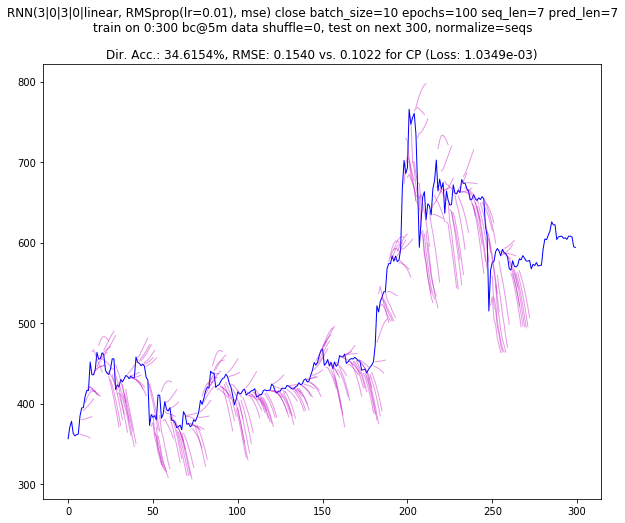

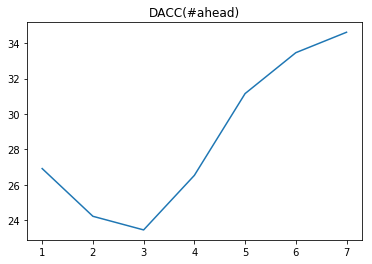

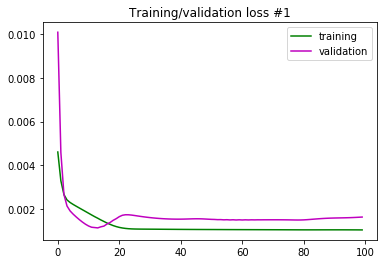

--- 25.620s to run experiment



In [9]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0, 3, 0],
            lr=1e-2,
        ),
        # training:
        epochs=100,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.016s to model compilation time


--- Created model id: 140222329290192
Tensor("lstm_41_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
lstm_42 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_21/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/50
277/277 [==============================] - 4s 13ms/step - loss: 0.0053 - val_loss: 0.0085
Epoch 2/50
277/277 [===========================

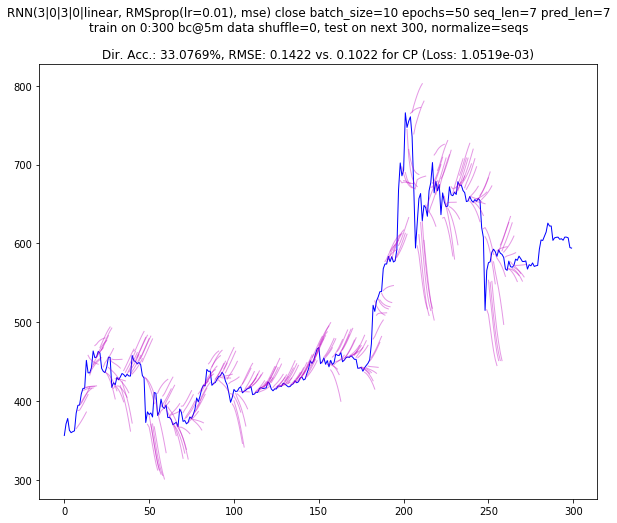

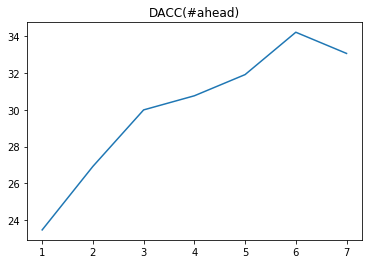

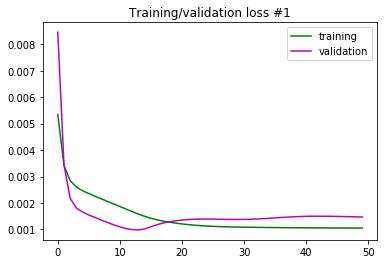

--- 18.178s to run experiment



In [17]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0, 3, 0],
            lr=1e-2,
        ),
        # training:
        epochs=50,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.016s to model compilation time


--- Created model id: 140222203025424
Tensor("lstm_57_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
lstm_58 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_29/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/12
277/277 [==============================] - 5s 17ms/step - loss: 0.0042 - val_loss: 0.0078
Epoch 2/12
277/277 [===========================

277/277 [==============================] - 0s 770us/step - loss: 0.0018 - val_loss: 0.0011
--- 8.404s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
--- 1.915s to walk and predict

--- 0.264s to plot incremental predictions

--- 0.016s to model compilation time


--- Created model id: 14

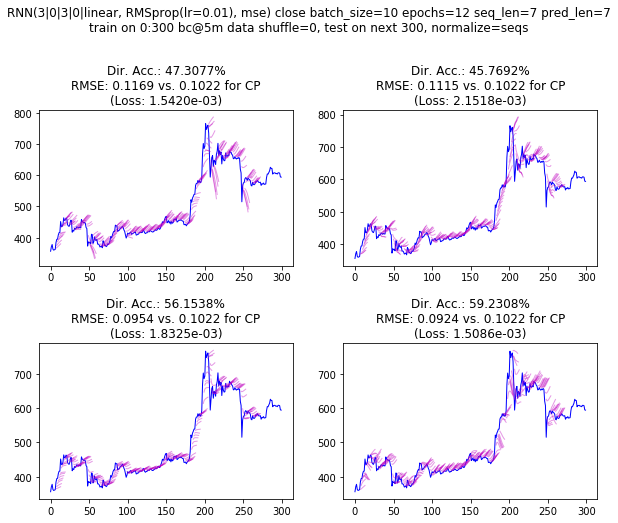

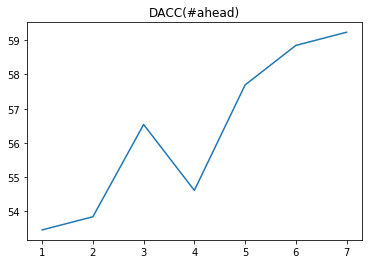

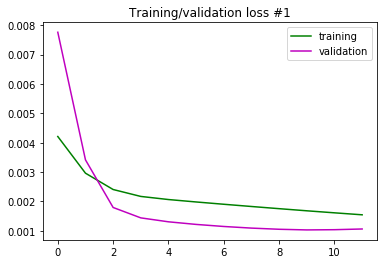

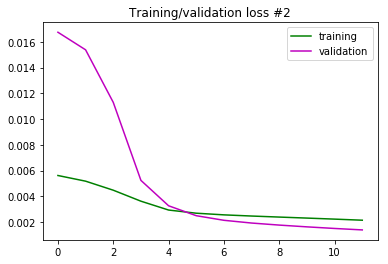

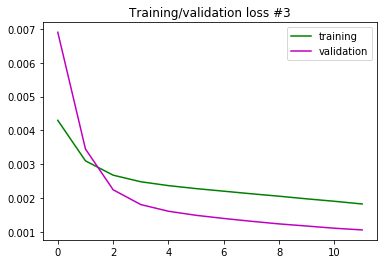

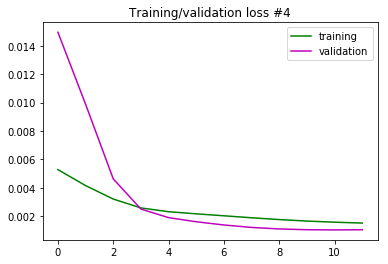

--- 45.033s to run experiment



In [25]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0, 3, 0],
            lr=1e-2,
        ),
        # training:
        epochs=12,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.034s to model compilation time


--- Created model id: 140222116334288
Tensor("lstm_65_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
lstm_66 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_33/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/6
277/277 [==============================] - 5s 19ms/step - loss: 0.0059 - val_loss: 0.0176
Epoch 2/6
277/277 [=============================

277/277 [==============================] - 5s 20ms/step - loss: 0.0055 - val_loss: 0.0161
Epoch 2/6
277/277 [==============================] - 0s 861us/step - loss: 0.0044 - val_loss: 0.0109
Epoch 3/6
277/277 [==============================] - 0s 934us/step - loss: 0.0033 - val_loss: 0.0047
Epoch 4/6
277/277 [==============================] - 0s 935us/step - loss: 0.0026 - val_loss: 0.0025
Epoch 5/6
277/277 [==============================] - 0s 815us/step - loss: 0.0023 - val_loss: 0.0019
Epoch 6/6
277/277 [==============================] - 0s 822us/step - loss: 0.0022 - val_loss: 0.0017
--- 7.970s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting

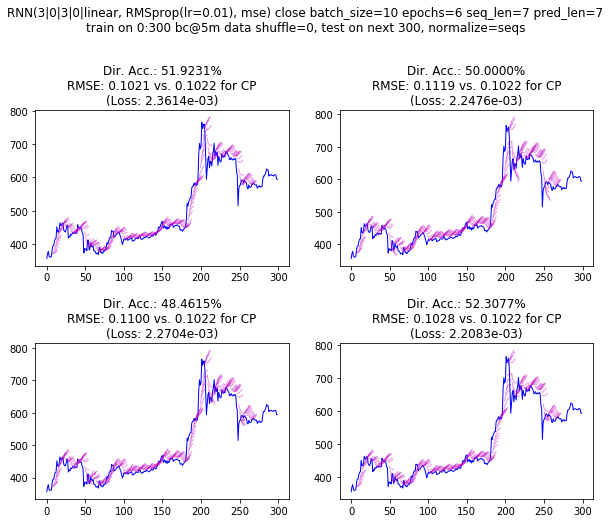

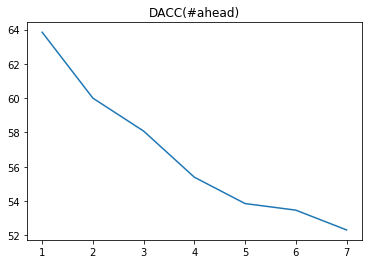

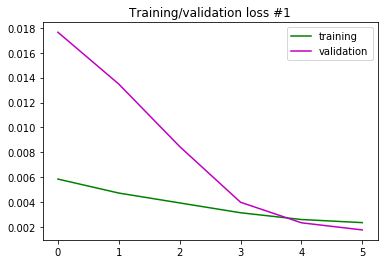

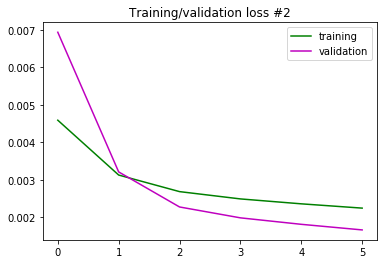

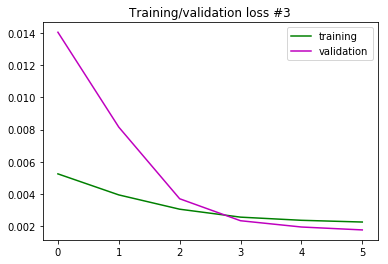

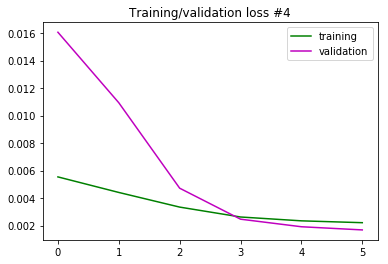

--- 47.236s to run experiment



In [26]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0, 3, 0],
            lr=1e-2,
        ),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

### LR=1e-4

data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140221909708048
Tensor("lstm_93_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 7, 3)              60        
_________________________________________________________________
lstm_94 (LSTM)               (None, 3)                 84        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_47/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/80
277/277 [==============================] - 7s 25ms/step - loss: 0.0063 - val_loss: 0.0089
Epoch 2/80
277/277 [===========================

277/277 [==============================] - 0s 764us/step - loss: 0.0044 - val_loss: 0.0065
Epoch 72/80
277/277 [==============================] - 0s 788us/step - loss: 0.0043 - val_loss: 0.0064
Epoch 73/80
277/277 [==============================] - 0s 782us/step - loss: 0.0043 - val_loss: 0.0064
Epoch 74/80
277/277 [==============================] - 0s 793us/step - loss: 0.0043 - val_loss: 0.0063
Epoch 75/80
277/277 [==============================] - 0s 783us/step - loss: 0.0043 - val_loss: 0.0063
Epoch 76/80
277/277 [==============================] - 0s 792us/step - loss: 0.0043 - val_loss: 0.0062
Epoch 77/80
277/277 [==============================] - 0s 760us/step - loss: 0.0042 - val_loss: 0.0062
Epoch 78/80
277/277 [==============================] - 0s 826us/step - loss: 0.0042 - val_loss: 0.0061
Epoch 79/80
277/277 [==============================] - 0s 933us/step - loss: 0.0042 - val_loss: 0.0061
Epoch 80/80
277/277 [==============================] - 0s 954us/step - loss: 0.0042 -

277/277 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0057
Epoch 54/80
277/277 [==============================] - 0s 953us/step - loss: 0.0040 - val_loss: 0.0056
Epoch 55/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 56/80
277/277 [==============================] - 0s 977us/step - loss: 0.0039 - val_loss: 0.0055
Epoch 57/80
277/277 [==============================] - 0s 954us/step - loss: 0.0039 - val_loss: 0.0055
Epoch 58/80
277/277 [==============================] - 0s 983us/step - loss: 0.0039 - val_loss: 0.0054
Epoch 59/80
277/277 [==============================] - 0s 988us/step - loss: 0.0039 - val_loss: 0.0054
Epoch 60/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 61/80
277/277 [==============================] - 0s 985us/step - loss: 0.0038 - val_loss: 0.0052
Epoch 62/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_los

277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0088
Epoch 36/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0088
Epoch 37/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0087
Epoch 38/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0087
Epoch 39/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0087
Epoch 40/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0087
Epoch 41/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0086
Epoch 42/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0086
Epoch 43/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0086
Epoch 44/80
277/277 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0086
Ep

Epoch 18/80
277/277 [==============================] - 0s 815us/step - loss: 0.0056 - val_loss: 0.0094
Epoch 19/80
277/277 [==============================] - 0s 849us/step - loss: 0.0056 - val_loss: 0.0094
Epoch 20/80
277/277 [==============================] - 0s 841us/step - loss: 0.0056 - val_loss: 0.0094
Epoch 21/80
277/277 [==============================] - 0s 863us/step - loss: 0.0056 - val_loss: 0.0093
Epoch 22/80
277/277 [==============================] - ETA: 0s - loss: 0.003 - 0s 981us/step - loss: 0.0055 - val_loss: 0.0093
Epoch 23/80
277/277 [==============================] - 0s 818us/step - loss: 0.0055 - val_loss: 0.0093
Epoch 24/80
277/277 [==============================] - 0s 767us/step - loss: 0.0055 - val_loss: 0.0092
Epoch 25/80
277/277 [==============================] - 0s 909us/step - loss: 0.0055 - val_loss: 0.0092
Epoch 26/80
277/277 [==============================] - 0s 939us/step - loss: 0.0055 - val_loss: 0.0092
Epoch 27/80
277/277 [============================

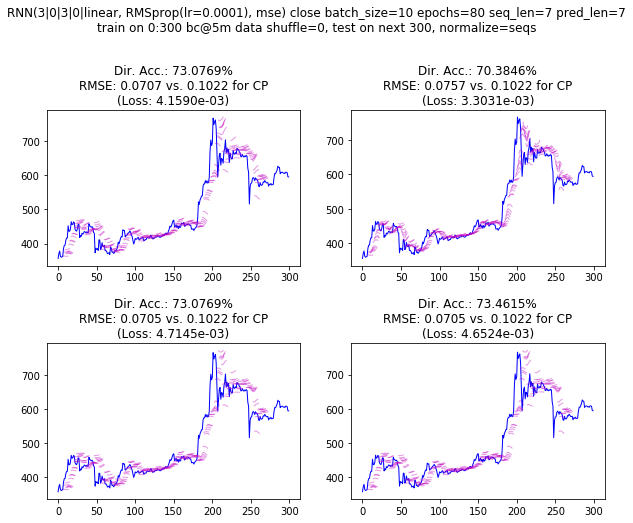

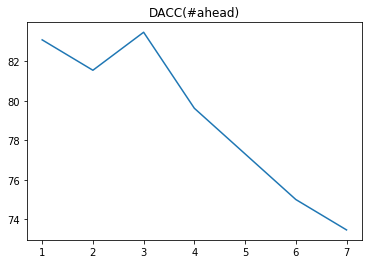

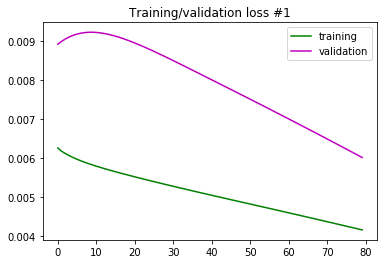

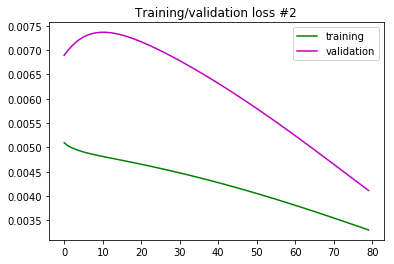

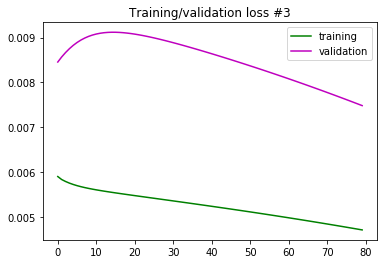

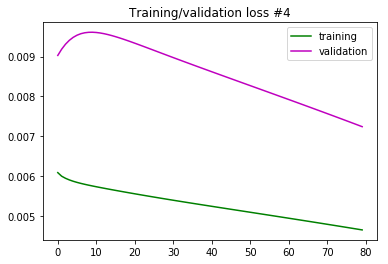

--- 135.517s to run experiment



In [34]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0, 3, 0],
            lr=1e-4,
        ),
        # training:
        epochs=80,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

## Size 7|7

### LR=1e-3

In [ ]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [3, 0, 3, 0],
            lr=1e-3,
        ),
        # training:
        epochs=100,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140221548157008
Tensor("lstm_131_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_131 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
lstm_132 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_66/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/100
277/277 [==============================] - 10s 35ms/step - loss: 0.0060 - val_loss: 0.0100
Epoch 2/100
277/277 [=======================

277/277 [==============================] - 0s 896us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 71/100
277/277 [==============================] - 0s 873us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 72/100
277/277 [==============================] - 0s 923us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 73/100
277/277 [==============================] - 0s 920us/step - loss: 0.0016 - val_loss: 0.0013
Epoch 74/100
277/277 [==============================] - 0s 837us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 75/100
277/277 [==============================] - 0s 897us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 76/100
277/277 [==============================] - 0s 844us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 77/100
277/277 [==============================] - 0s 966us/step - loss: 0.0015 - val_loss: 0.0013
Epoch 78/100
277/277 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 79/100
277/277 [==============================] - 0s 973us/step - loss: 0

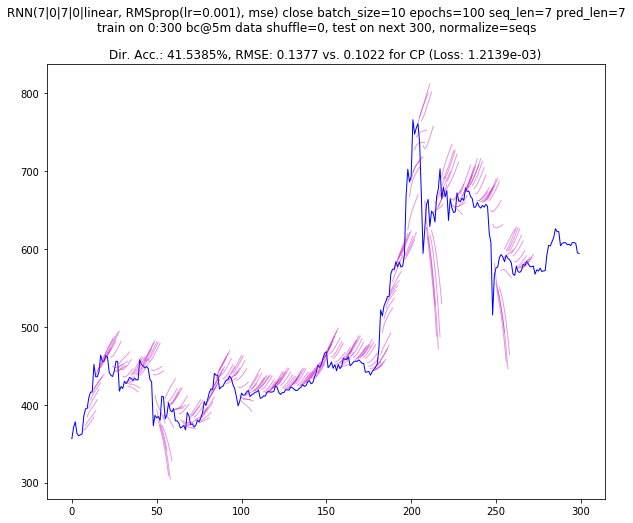

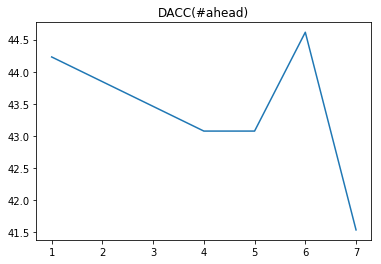

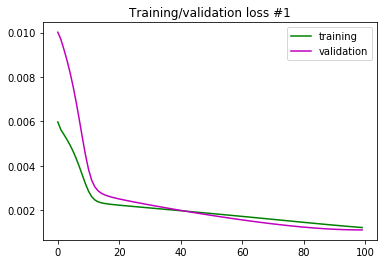

--- 42.704s to run experiment



In [41]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0, 7, 0],
            lr=1e-3,
        ),
        # training:
        epochs=100,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.017s to model compilation time


--- Created model id: 140221680324688
Tensor("lstm_139_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_139 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
lstm_140 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dense_70 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_70/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/6
277/277 [==============================] - 10s 38ms/step - loss: 0.0050 - val_loss: 0.0084
Epoch 2/6
277/277 [===========================

Train on 277 samples, validate on 15 samples
Epoch 1/6
277/277 [==============================] - 11s 40ms/step - loss: 0.0049 - val_loss: 0.0079
Epoch 2/6
277/277 [==============================] - 0s 948us/step - loss: 0.0046 - val_loss: 0.0076
Epoch 3/6
277/277 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0071
Epoch 4/6
277/277 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 5/6
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0059
Epoch 6/6
277/277 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0053
--- 14.421s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 

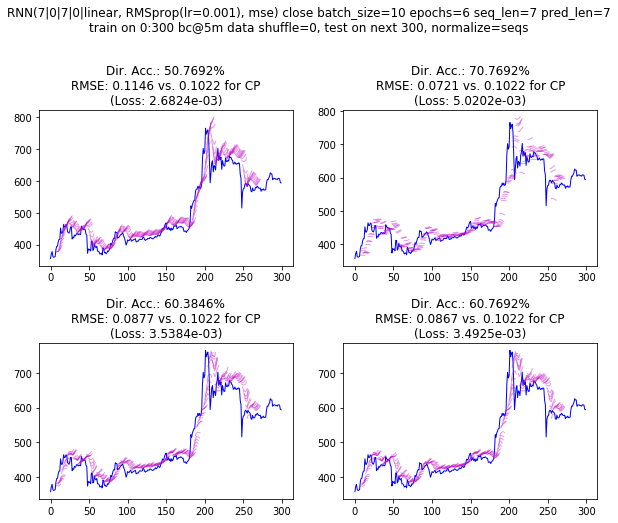

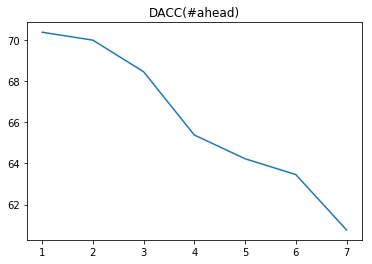

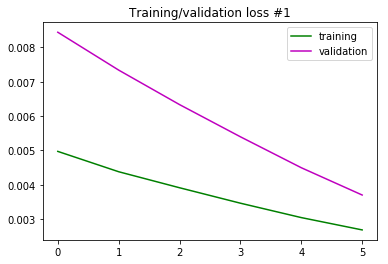

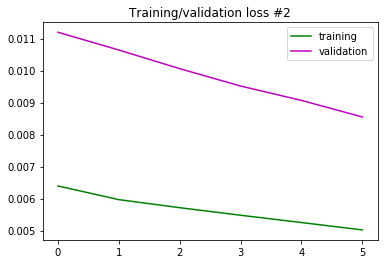

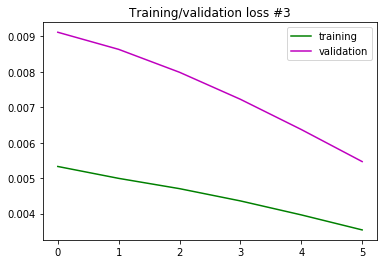

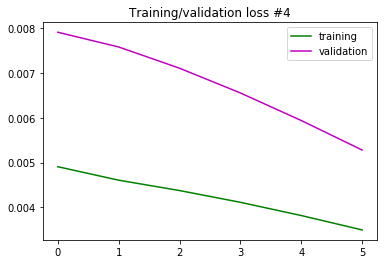

--- 79.096s to run experiment



In [45]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0, 7, 0],
            lr=1e-3,
        ),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

#### add dropout

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140221349035984
Tensor("lstm_155_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_155 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_25 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_156 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_26 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
__________________________________________________________

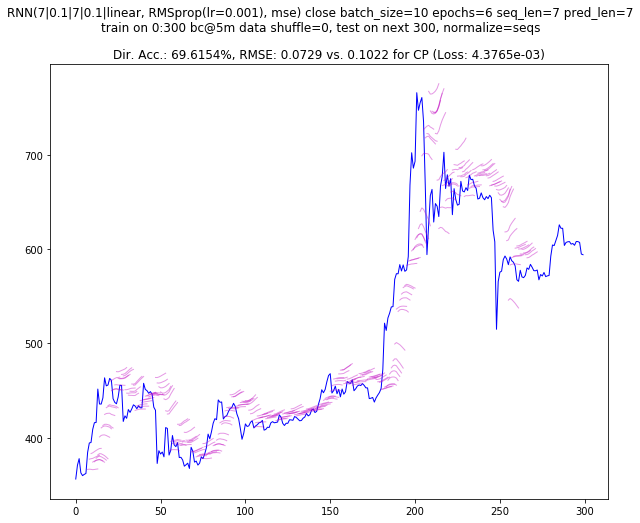

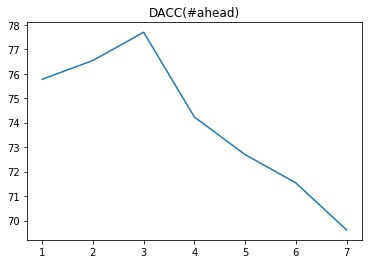

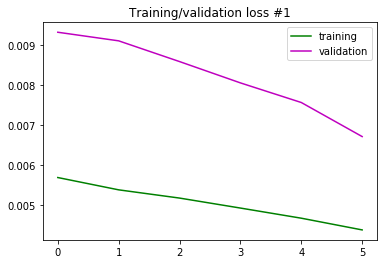

--- 21.522s to run experiment



In [47]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0.1, 7, 0.2],
            lr=1e-3,
        ),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

### LR=1e-2

data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140221325722384
Tensor("lstm_157_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_157 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
lstm_158 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_79/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/50
277/277 [==============================] - 12s 43ms/step - loss: 0.0054 - val_loss: 0.0050
Epoch 2/50
277/277 [=========================

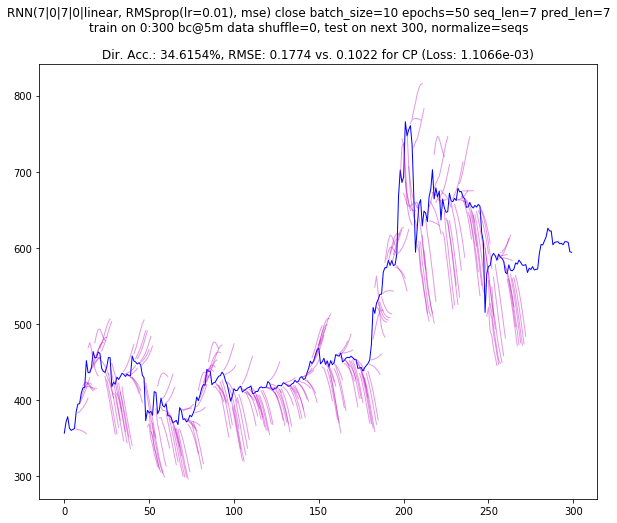

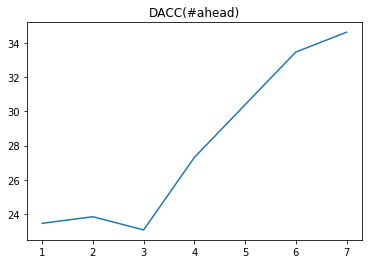

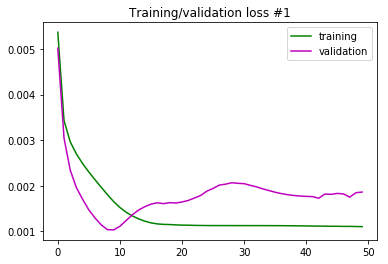

--- 33.564s to run experiment



In [48]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0, 7, 0],
            lr=1e-2,
        ),
        # training:
        epochs=50,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140221237474832
Tensor("lstm_165_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_165 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
lstm_166 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_83/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/15
277/277 [==============================] - 12s 44ms/step - loss: 0.0057 - val_loss: 0.0165
Epoch 2/15
277/277 [=========================

277/277 [==============================] - 0s 902us/step - loss: 0.0022 - val_loss: 0.0015
Epoch 7/15
277/277 [==============================] - 0s 737us/step - loss: 0.0021 - val_loss: 0.0013
Epoch 8/15
277/277 [==============================] - 0s 831us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 9/15
277/277 [==============================] - 0s 939us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/15
277/277 [==============================] - 0s 944us/step - loss: 0.0016 - val_loss: 9.9379e-04
Epoch 11/15
277/277 [==============================] - 0s 1ms/step - loss: 0.0015 - val_loss: 9.9487e-04
Epoch 12/15
277/277 [==============================] - 0s 1ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 13/15
277/277 [==============================] - 0s 984us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 14/15
277/277 [==============================] - 0s 975us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 15/15
277/277 [==============================] - 0s 1ms/step - loss: 0.0012 - 

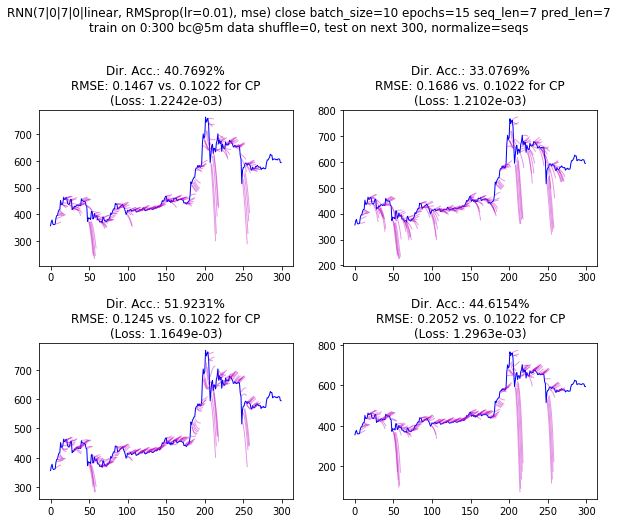

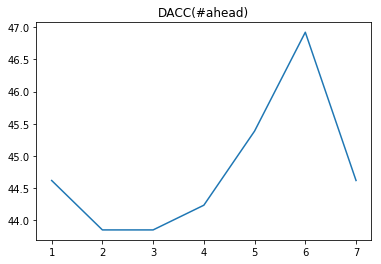

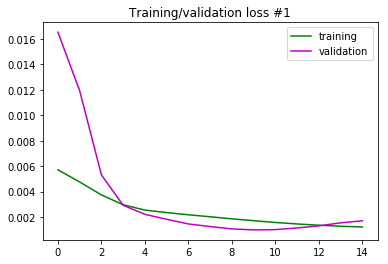

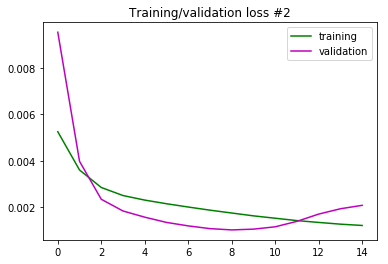

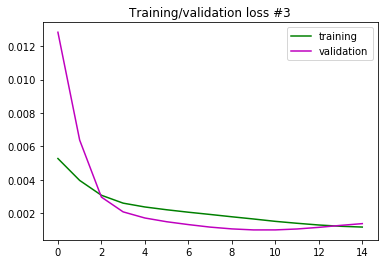

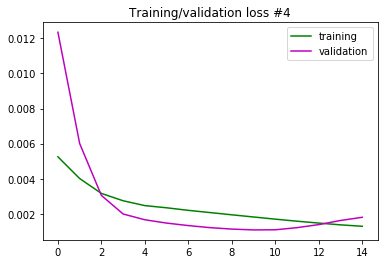

--- 111.546s to run experiment



In [52]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0, 7, 0],
            lr=1e-2,
        ),
        # training:
        epochs=15,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

### LR=1e-4

data ~ (600, 1)
--- 0.018s to model compilation time


--- Created model id: 140221203521232
Tensor("lstm_175_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_175 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
lstm_176 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_88/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/200
277/277 [==============================] - 14s 51ms/step - loss: 0.0057 - val_loss: 0.0081
Epoch 2/200
277/277 [=======================

Epoch 71/200
277/277 [==============================] - 0s 981us/step - loss: 0.0026 - val_loss: 0.0028
Epoch 72/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 73/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 74/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 75/200
277/277 [==============================] - 0s 959us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 76/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 77/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 78/200
277/277 [==============================] - 0s 993us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 79/200
277/277 [==============================] - 0s 981us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 80/200
277/277 [==============================] - 0s 965us/step - lo

277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 151/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 152/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 153/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 154/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 155/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 156/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 157/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 158/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 159/200
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - v

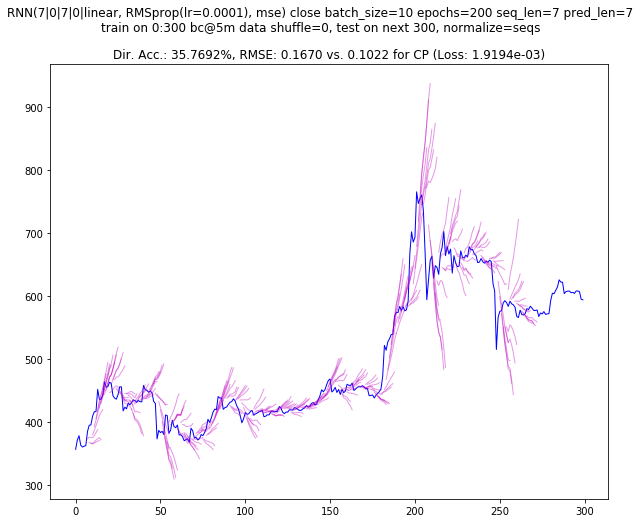

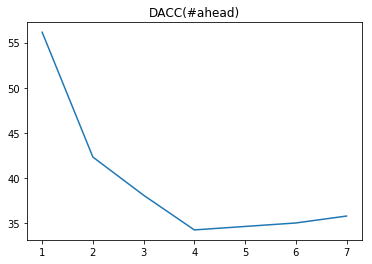

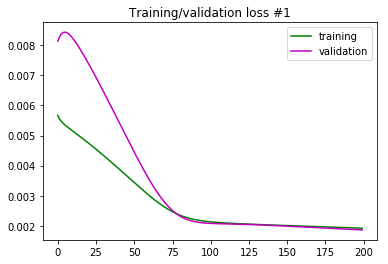

--- 81.078s to run experiment



In [55]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0, 7, 0],
            lr=1e-4,
        ),
        # training:
        epochs=200,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140221159541904
Tensor("lstm_179_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_179 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
lstm_180 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_90/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/60
277/277 [==============================] - 14s 51ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 2/60
277/277 [=========================

Train on 277 samples, validate on 15 samples
Epoch 1/60
277/277 [==============================] - 14s 52ms/step - loss: 0.0055 - val_loss: 0.0078
Epoch 2/60
277/277 [==============================] - 0s 980us/step - loss: 0.0054 - val_loss: 0.0079
Epoch 3/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0080
Epoch 4/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0081
Epoch 5/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 6/60
277/277 [==============================] - 0s 987us/step - loss: 0.0052 - val_loss: 0.0081
Epoch 7/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 8/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0081
Epoch 9/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0081
Epoch 10/60
277/277 [============================

277/277 [==============================] - 0s 983us/step - loss: 0.0058 - val_loss: 0.0089
Epoch 4/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0058 - val_loss: 0.0090
Epoch 5/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0090
Epoch 6/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0091
Epoch 7/60
277/277 [==============================] - 0s 996us/step - loss: 0.0057 - val_loss: 0.0091
Epoch 8/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0091
Epoch 9/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0091
Epoch 10/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0056 - val_loss: 0.0091
Epoch 11/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0090
Epoch 12/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0090
Epoc

277/277 [==============================] - 0s 1ms/step - loss: 0.0064 - val_loss: 0.0108
Epoch 7/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0108
Epoch 8/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0108
Epoch 9/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0107
Epoch 10/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0107
Epoch 11/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0062 - val_loss: 0.0106
Epoch 12/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0106
Epoch 13/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0105
Epoch 14/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0104
Epoch 15/60
277/277 [==============================] - 0s 1ms/step - loss: 0.0060 - val_loss: 0.0104
Epoch

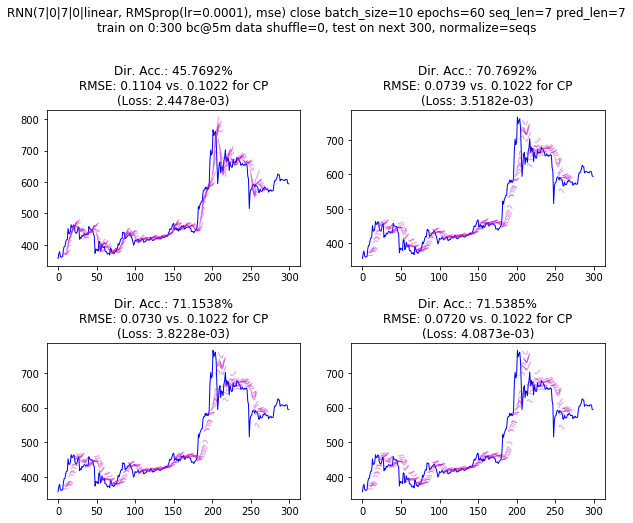

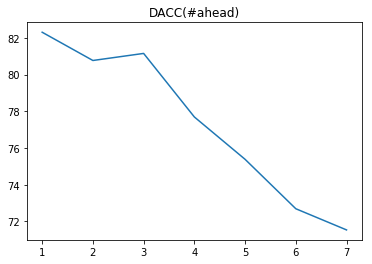

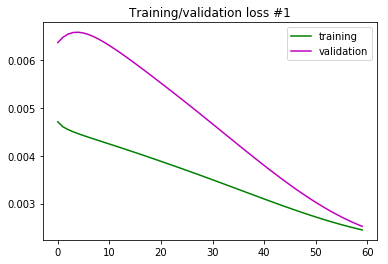

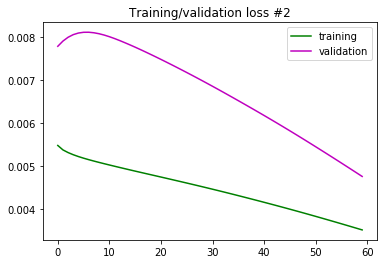

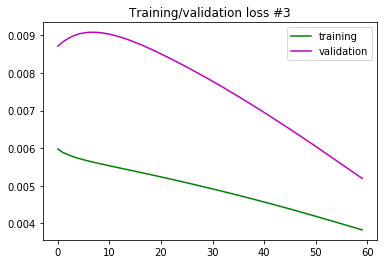

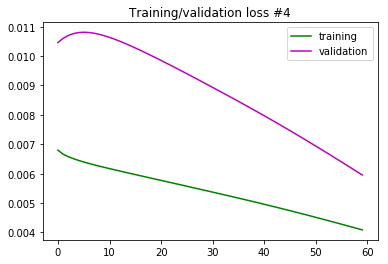

--- 166.952s to run experiment



In [57]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0, 7, 0],
            lr=1e-4,
        ),
        # training:
        epochs=60,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.022s to model compilation time


--- Created model id: 140220913931600
Tensor("lstm_203_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_203 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
lstm_204 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
_________________________________________________________________
None
Tensor("dense_102/BiasAdd:0", shape=(?, 1), dtype=float32)

Train on 277 samples, validate on 15 samples
Epoch 1/40
277/277 [==============================] - 24s 85ms/step - loss: 0.0052 - val_loss: 0.0073
Epoch 2/40
277/277 [========================

277/277 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0088
Epoch 15/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0087
Epoch 16/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0086
Epoch 17/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0086
Epoch 18/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0085
Epoch 19/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0084
Epoch 20/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0083
Epoch 21/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0083
Epoch 22/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0082
Epoch 23/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0051 - val_loss: 0.0081
Ep

277/277 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 38/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 39/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 40/40
277/277 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0041
--- 30.755s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predictin

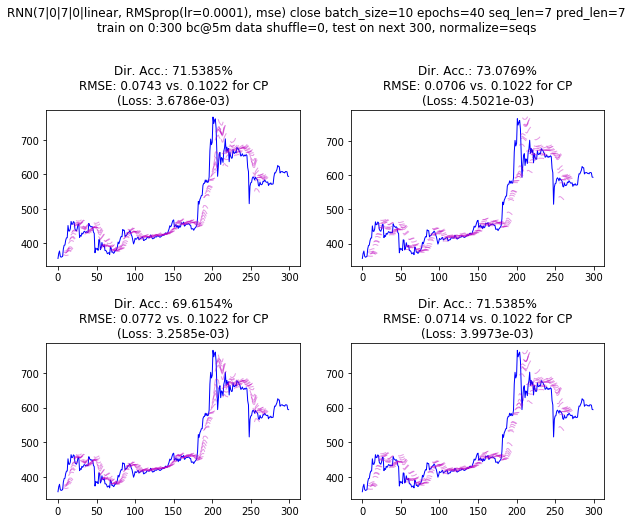

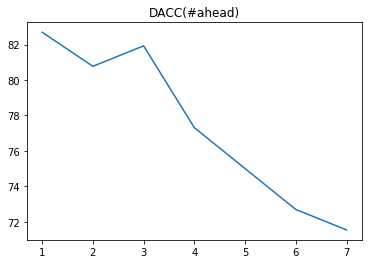

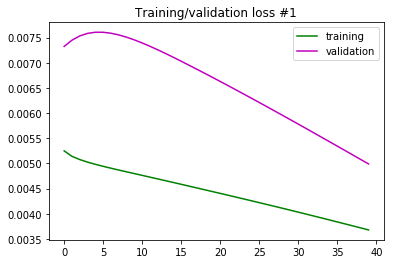

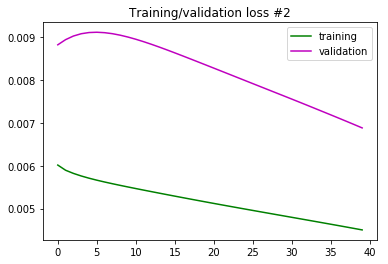

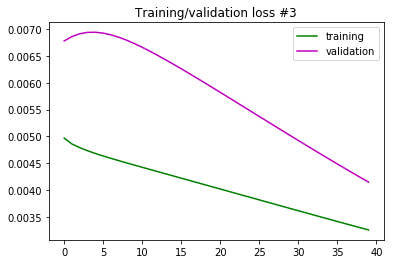

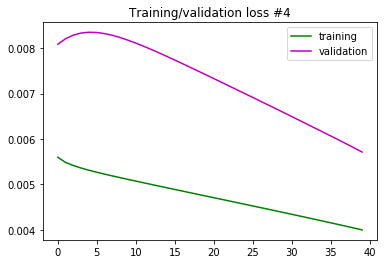

--- 162.962s to run experiment



In [60]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0, 7, 0],
            lr=1e-4,
        ),
        # training:
        epochs=40,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

#### add dropout

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140220822748048
Tensor("lstm_217_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_217 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_33 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_218 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_34 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
__________________________________________________________

277/277 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0042
Epoch 70/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 71/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 72/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 73/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0031 - val_loss: 0.0039
Epoch 74/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 75/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 76/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 77/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 78/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0030 - val_loss: 

Epoch 149/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 150/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 0.0020
--- 67.555s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
--- 7.441s to walk and 

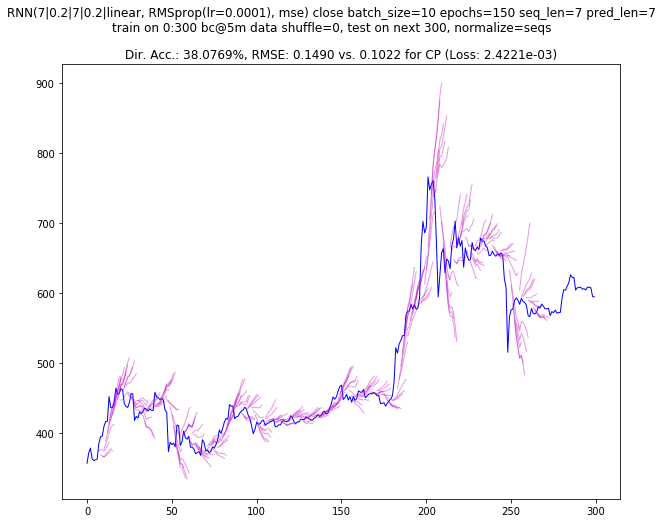

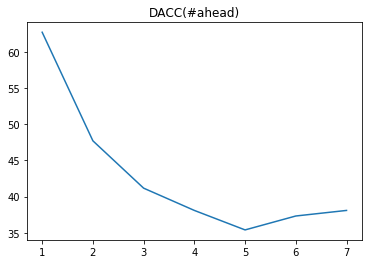

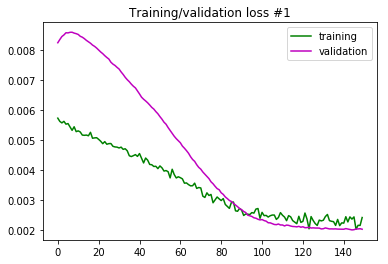

--- 76.437s to run experiment



In [63]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0.2, 7, 0.2],
            lr=1e-4,
        ),
        # training:
        epochs=150,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140220578299088
Tensor("lstm_239_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_239 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_55 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_240 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_56 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
__________________________________________________________

277/277 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 70/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 71/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 72/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 73/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 74/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 75/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0026
Epoch 76/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 77/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 78/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0024 - val_loss: 

Epoch 149/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 150/150
277/277 [==============================] - 0s 1ms/step - loss: 0.0022 - val_loss: 0.0020
--- 70.911s to train model

> Predicting (now at 0)...
> Predicting (now at 10)...
> Predicting (now at 20)...
> Predicting (now at 30)...
> Predicting (now at 40)...
> Predicting (now at 50)...
> Predicting (now at 60)...
> Predicting (now at 70)...
> Predicting (now at 80)...
> Predicting (now at 90)...
> Predicting (now at 100)...
> Predicting (now at 110)...
> Predicting (now at 120)...
> Predicting (now at 130)...
> Predicting (now at 140)...
> Predicting (now at 150)...
> Predicting (now at 160)...
> Predicting (now at 170)...
> Predicting (now at 180)...
> Predicting (now at 190)...
> Predicting (now at 200)...
> Predicting (now at 210)...
> Predicting (now at 220)...
> Predicting (now at 230)...
> Predicting (now at 240)...
> Predicting (now at 250)...
--- 8.497s to walk and 

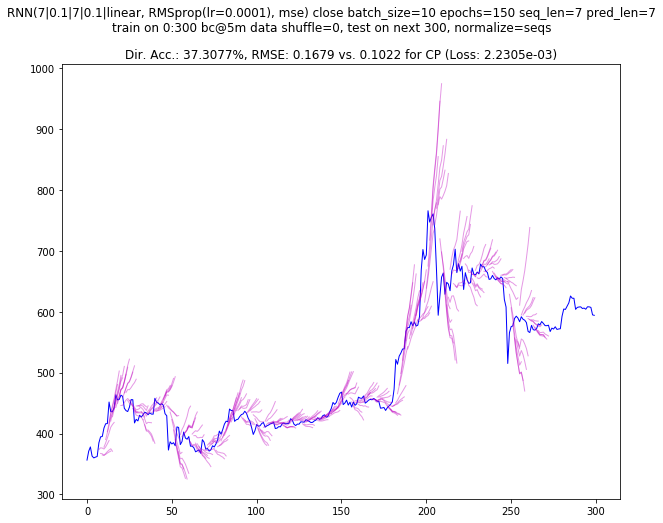

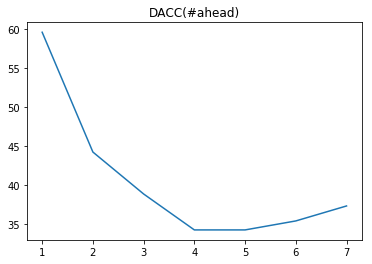

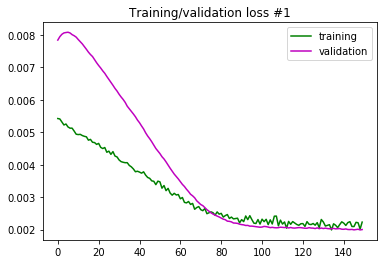

--- 80.891s to run experiment



In [68]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0.1, 7, 0.1],
            lr=1e-4,
        ),
        # training:
        epochs=150,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.020s to model compilation time


--- Created model id: 140220667856912
Tensor("lstm_231_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_231 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_47 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_232 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_48 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_116 (Dense)            (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
__________________________________________________________

277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 5/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 6/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 7/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 8/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 9/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 10/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 11/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 12/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0066
Epoch 13/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 1

277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 20/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0070
Epoch 21/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0069
Epoch 22/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0069
Epoch 23/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 24/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 25/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 26/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0066
Epoch 27/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 28/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0064
Ep

277/277 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0055
Epoch 35/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 36/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0054
Epoch 37/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 38/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0052
Epoch 39/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0051
Epoch 40/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 41/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 42/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 43/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0047
Ep

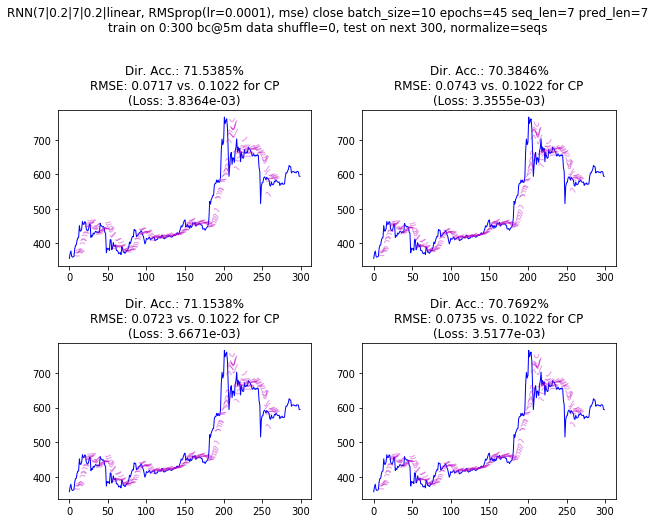

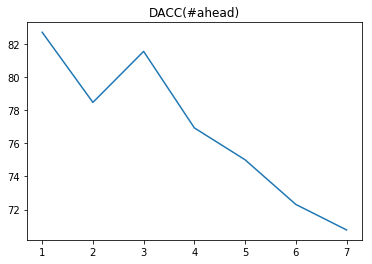

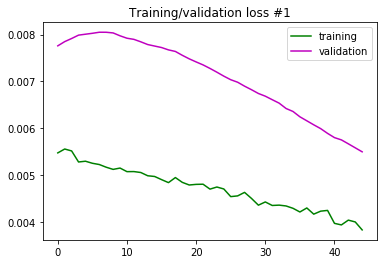

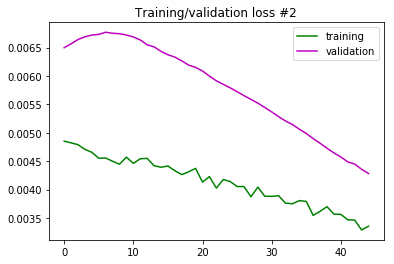

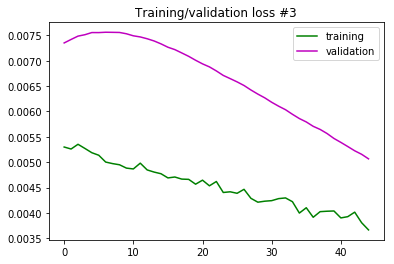

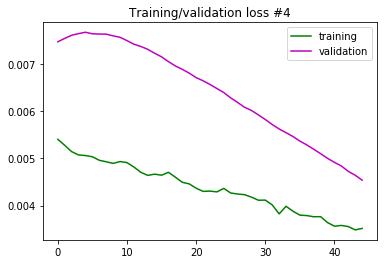

--- 182.017s to run experiment



In [67]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0.2, 7, 0.2],
            lr=1e-4,
        ),
        # training:
        epochs=45,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.019s to model compilation time


--- Created model id: 140220531214800
Tensor("lstm_243_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_243 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_59 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_244 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_60 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
__________________________________________________________

277/277 [==============================] - 0s 988us/step - loss: 0.0049 - val_loss: 0.0072
Epoch 5/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0072
Epoch 6/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0072
Epoch 7/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0073
Epoch 8/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 9/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 10/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 11/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0073
Epoch 12/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0072
Epoch 13/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0072
Epoch

277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0072
Epoch 20/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0072
Epoch 21/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0071
Epoch 22/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0070
Epoch 23/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0069
Epoch 24/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0046 - val_loss: 0.0069
Epoch 25/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 26/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 27/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 28/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0044 - val_loss: 0.0066
Ep

277/277 [==============================] - 0s 1ms/step - loss: 0.0039 - val_loss: 0.0055
Epoch 35/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0054
Epoch 36/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 37/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 38/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0052
Epoch 39/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 40/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 41/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 42/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0049
Epoch 43/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0048
Ep

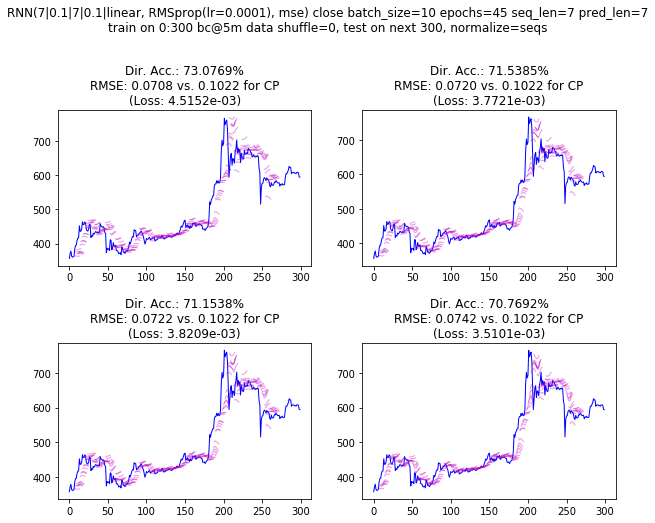

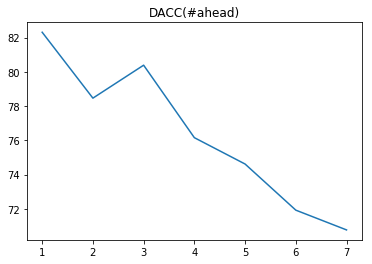

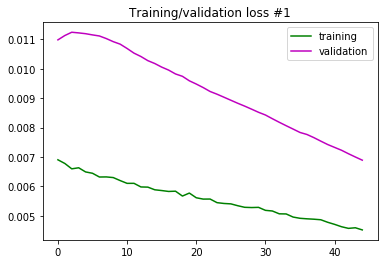

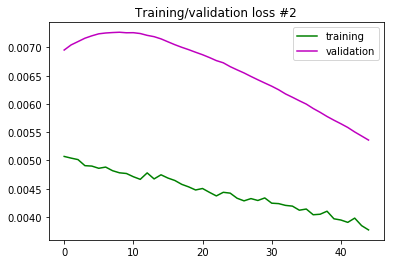

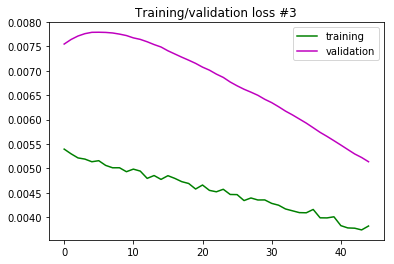

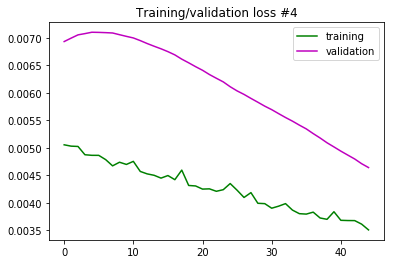

--- 316.223s to run experiment



In [70]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0.1, 7, 0.1],
            lr=1e-4,
        ),
        # training:
        epochs=45,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.020s to model compilation time


--- Created model id: 140220524987664
Tensor("lstm_253_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_253 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_69 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_254 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_70 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_127 (Dense)            (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
__________________________________________________________

277/277 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0085
Epoch 5/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0083
Epoch 6/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0081
Epoch 7/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0080
Epoch 8/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0078
Epoch 9/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0077
Epoch 10/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0076
Epoch 11/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0075
Epoch 12/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0074
Epoch 13/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0073
Epoch 1

277/277 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0078
Epoch 20/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0077
Epoch 21/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0050 - val_loss: 0.0077
Epoch 22/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0076
Epoch 23/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0075
Epoch 24/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0075
Epoch 25/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0074
Epoch 26/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 27/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0047 - val_loss: 0.0073
Epoch 28/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0072
Ep

277/277 [==============================] - 0s 1ms/step - loss: 0.0036 - val_loss: 0.0050
Epoch 35/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0049
Epoch 36/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 37/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 38/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 39/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 40/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 41/45
277/277 [==============================] - 0s 2ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 42/45
277/277 [==============================] - 0s 2ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 43/45
277/277 [==============================] - 0s 1ms/step - loss: 0.0032 - val_loss: 0.0042
Ep

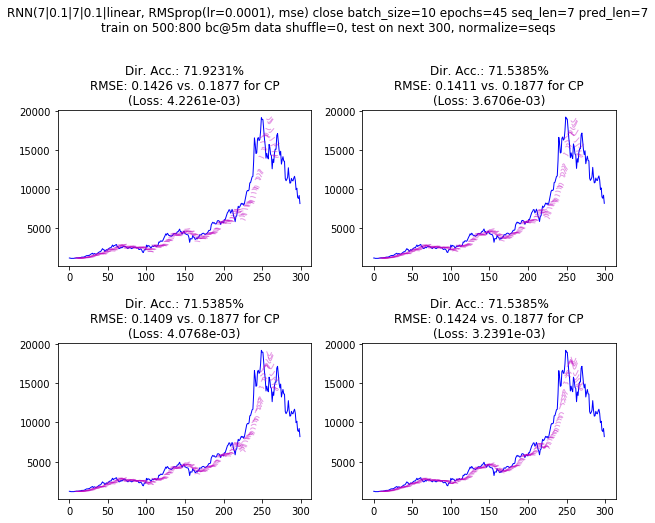

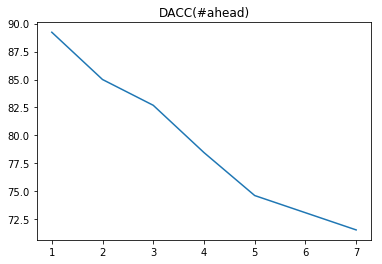

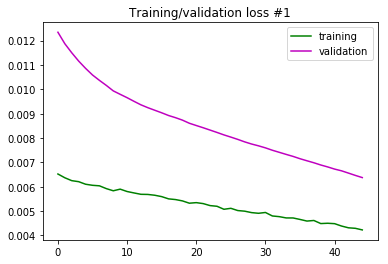

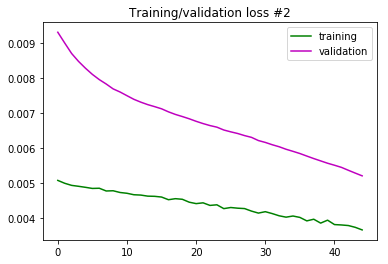

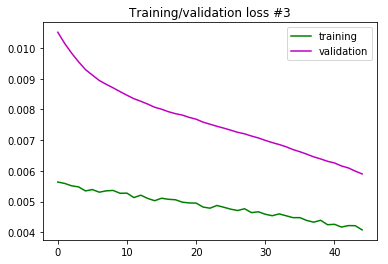

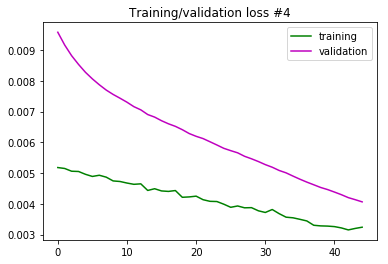

--- 200.965s to run experiment



In [72]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0.1, 7, 0.1],
            lr=1e-4,
        ),
        # training:
        epochs=45,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

#### batch_size tweaking

data ~ (600, 1)
--- 0.031s to model compilation time


--- Created model id: 140220267224080
Tensor("lstm_277_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_277 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_93 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_278 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_94 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
__________________________________________________________

Epoch 68/120
277/277 [==============================] - 0s 447us/step - loss: 0.0054 - val_loss: 0.0093
Epoch 69/120
277/277 [==============================] - 0s 425us/step - loss: 0.0054 - val_loss: 0.0093
Epoch 70/120
277/277 [==============================] - 0s 434us/step - loss: 0.0054 - val_loss: 0.0092
Epoch 71/120
277/277 [==============================] - 0s 437us/step - loss: 0.0054 - val_loss: 0.0092
Epoch 72/120
277/277 [==============================] - 0s 428us/step - loss: 0.0054 - val_loss: 0.0092
Epoch 73/120
277/277 [==============================] - 0s 427us/step - loss: 0.0054 - val_loss: 0.0092
Epoch 74/120
277/277 [==============================] - 0s 448us/step - loss: 0.0053 - val_loss: 0.0092
Epoch 75/120
277/277 [==============================] - 0s 423us/step - loss: 0.0054 - val_loss: 0.0092
Epoch 76/120
277/277 [==============================] - 0s 438us/step - loss: 0.0054 - val_loss: 0.0091
Epoch 77/120
277/277 [==============================] - 0s 443us

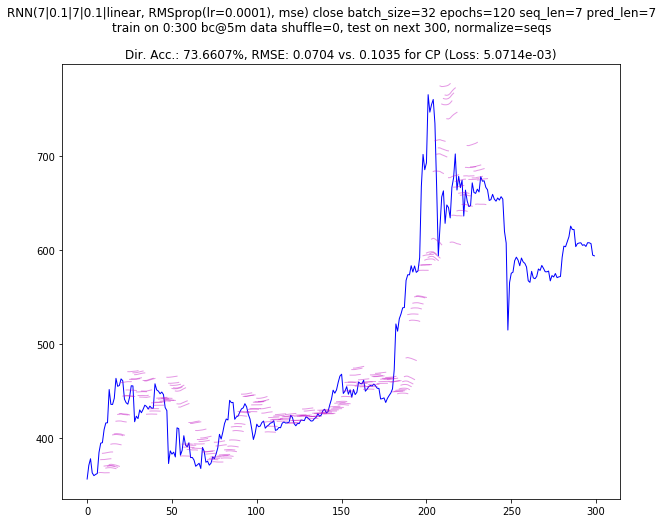

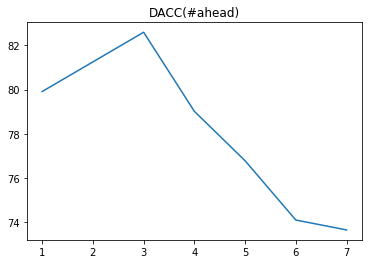

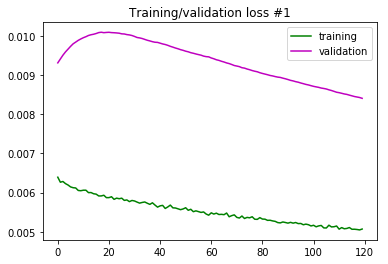

--- 53.619s to run experiment



In [80]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0.1, 7, 0.1],
            lr=1e-4,
        ),
        # training:
        epochs=120,
        batch_size=32,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])

data ~ (600, 1)
--- 0.020s to model compilation time


--- Created model id: 140220244024912
Tensor("lstm_287_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_287 (LSTM)              (None, 7, 7)              252       
_________________________________________________________________
dropout_103 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_288 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_104 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_144 (Dense)            (None, 1)                 8         
Total params: 680
Trainable params: 680
Non-trainable params: 0
__________________________________________________________

Epoch 68/100
277/277 [==============================] - 0s 423us/step - loss: 0.0047 - val_loss: 0.0077
Epoch 69/100
277/277 [==============================] - 0s 442us/step - loss: 0.0047 - val_loss: 0.0077
Epoch 70/100
277/277 [==============================] - 0s 433us/step - loss: 0.0047 - val_loss: 0.0077
Epoch 71/100
277/277 [==============================] - 0s 434us/step - loss: 0.0047 - val_loss: 0.0077
Epoch 72/100
277/277 [==============================] - 0s 419us/step - loss: 0.0047 - val_loss: 0.0076
Epoch 73/100
277/277 [==============================] - 0s 445us/step - loss: 0.0048 - val_loss: 0.0076
Epoch 74/100
277/277 [==============================] - 0s 442us/step - loss: 0.0047 - val_loss: 0.0076
Epoch 75/100
277/277 [==============================] - 0s 473us/step - loss: 0.0046 - val_loss: 0.0076
Epoch 76/100
277/277 [==============================] - 0s 441us/step - loss: 0.0047 - val_loss: 0.0075
Epoch 77/100
277/277 [==============================] - 0s 471us

277/277 [==============================] - 0s 419us/step - loss: 0.0056 - val_loss: 0.0095
Epoch 33/100
277/277 [==============================] - 0s 427us/step - loss: 0.0056 - val_loss: 0.0095
Epoch 34/100
277/277 [==============================] - 0s 434us/step - loss: 0.0056 - val_loss: 0.0095
Epoch 35/100
277/277 [==============================] - 0s 431us/step - loss: 0.0056 - val_loss: 0.0095
Epoch 36/100
277/277 [==============================] - 0s 422us/step - loss: 0.0055 - val_loss: 0.0095
Epoch 37/100
277/277 [==============================] - 0s 430us/step - loss: 0.0056 - val_loss: 0.0094
Epoch 38/100
277/277 [==============================] - 0s 422us/step - loss: 0.0056 - val_loss: 0.0094
Epoch 39/100
277/277 [==============================] - 0s 425us/step - loss: 0.0056 - val_loss: 0.0094
Epoch 40/100
277/277 [==============================] - 0s 427us/step - loss: 0.0055 - val_loss: 0.0094
Epoch 41/100
277/277 [==============================] - 0s 435us/step - loss:

Train on 277 samples, validate on 15 samples
Epoch 1/100
277/277 [==============================] - 24s 88ms/step - loss: 0.0072 - val_loss: 0.0108
Epoch 2/100
277/277 [==============================] - 0s 445us/step - loss: 0.0071 - val_loss: 0.0109
Epoch 3/100
277/277 [==============================] - 0s 466us/step - loss: 0.0071 - val_loss: 0.0110
Epoch 4/100
277/277 [==============================] - 0s 450us/step - loss: 0.0070 - val_loss: 0.0111
Epoch 5/100
277/277 [==============================] - 0s 446us/step - loss: 0.0070 - val_loss: 0.0112
Epoch 6/100
277/277 [==============================] - 0s 438us/step - loss: 0.0069 - val_loss: 0.0112
Epoch 7/100
277/277 [==============================] - 0s 437us/step - loss: 0.0068 - val_loss: 0.0113
Epoch 8/100
277/277 [==============================] - 0s 433us/step - loss: 0.0069 - val_loss: 0.0113
Epoch 9/100
277/277 [==============================] - 0s 452us/step - loss: 0.0069 - val_loss: 0.0114
Epoch 10/100
277/277 [======

277/277 [==============================] - 0s 465us/step - loss: 0.0059 - val_loss: 0.0102
Epoch 80/100
277/277 [==============================] - 0s 455us/step - loss: 0.0058 - val_loss: 0.0102
Epoch 81/100
277/277 [==============================] - 0s 449us/step - loss: 0.0058 - val_loss: 0.0102
Epoch 82/100
277/277 [==============================] - 0s 453us/step - loss: 0.0058 - val_loss: 0.0102
Epoch 83/100
277/277 [==============================] - 0s 438us/step - loss: 0.0058 - val_loss: 0.0102
Epoch 84/100
277/277 [==============================] - 0s 461us/step - loss: 0.0058 - val_loss: 0.0101
Epoch 85/100
277/277 [==============================] - 0s 487us/step - loss: 0.0058 - val_loss: 0.0101
Epoch 86/100
277/277 [==============================] - 0s 510us/step - loss: 0.0058 - val_loss: 0.0101
Epoch 87/100
277/277 [==============================] - 0s 493us/step - loss: 0.0057 - val_loss: 0.0101
Epoch 88/100
277/277 [==============================] - 0s 440us/step - loss:

277/277 [==============================] - 1s 4ms/step - loss: 0.0059 - val_loss: 0.0102
Epoch 44/100
277/277 [==============================] - 0s 305us/step - loss: 0.0059 - val_loss: 0.0102
Epoch 45/100
277/277 [==============================] - 0s 437us/step - loss: 0.0058 - val_loss: 0.0102
Epoch 46/100
277/277 [==============================] - 0s 486us/step - loss: 0.0058 - val_loss: 0.0101
Epoch 47/100
277/277 [==============================] - 0s 446us/step - loss: 0.0058 - val_loss: 0.0101
Epoch 48/100
277/277 [==============================] - 0s 464us/step - loss: 0.0058 - val_loss: 0.0101
Epoch 49/100
277/277 [==============================] - 0s 454us/step - loss: 0.0058 - val_loss: 0.0100
Epoch 50/100
277/277 [==============================] - 0s 448us/step - loss: 0.0057 - val_loss: 0.0100
Epoch 51/100
277/277 [==============================] - 0s 460us/step - loss: 0.0058 - val_loss: 0.0100
Epoch 52/100
277/277 [==============================] - 0s 470us/step - loss: 0

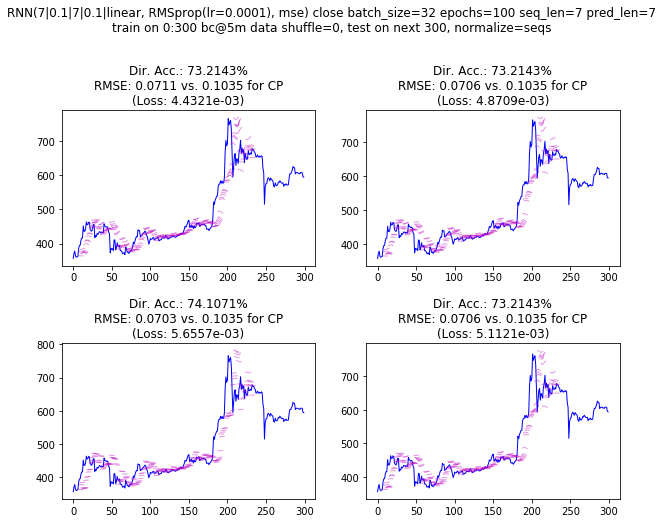

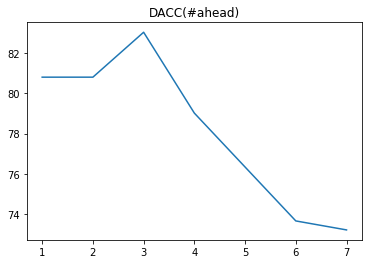

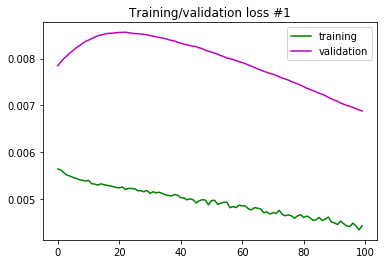

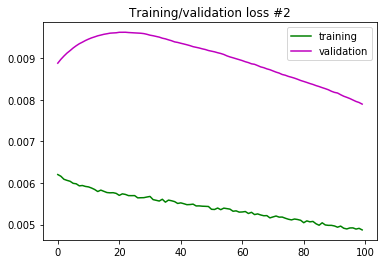

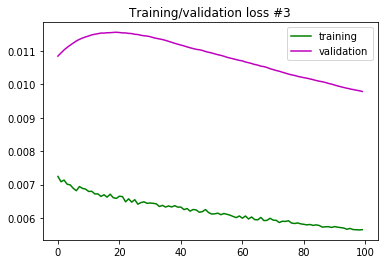

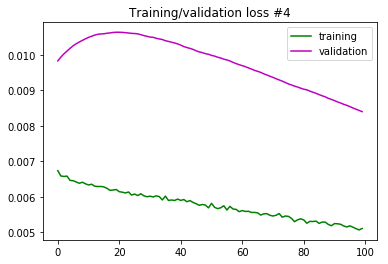

--- 411.606s to run experiment



In [82]:
with timing('run experiment'):
    res = run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor(
            [7, 0.1, 7, 0.1],
            lr=1e-4,
        ),
        # training:
        epochs=100,
        batch_size=32,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )
    plot_train_val_losses(res['train_val_losses'])